In [34]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)

In [152]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """


    def acc_cut(self, events):

        cut = (events.gLLP_csc == 1)
        return events[cut]
        #return events[ak.any(cut, axis = -1)]

    def met_cut(self, events):
        cut = events.metEENoise <= 20
        return events[cut]

    def csc_eff_cut(self, events):
        
        cut = (events.nCscRechitClusters >= 1)
        return events[cut]

    def muon_veto(self, events):
        
        cut = (events.cscRechitClusterMuonVetoPt < 20)
        return events[ak.any(cut, axis = -1)]

    def jet_cut(self, events):
        
        cut = (events.cscRechitClusterJetVetoPt < 10)
        return events[ak.any(cut, axis = -1)]

    def time_cut(self, events):

        cut = ((events.cscRechitClusterTimeWeighted <= 12.5)&
               (events.cscRechitClusterTimeWeighted >= -5  ))
        return events[ak.any(cut, axis = -1)]

    def ME11_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus11 <= 0))
        return events[ak.any(cut, axis = -1)]


    def ME12_veto(self, events):

        cut = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
               (events.cscRechitClusterNRechitChamberMinus12 <= 0))
        return events[ak.any(cut, axis = -1)]


    def re12_cut(self, events):
        
        cut = events.cscRechitCluster_match_RE12_0p4 == 0
        return events[ak.any(cut, axis = -1)]

    def mb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_MB1Seg_0p4 == 0
        return events[ak.any(cut, axis = -1)]

    def rb1_cut(self, events):
        
        cut = events.cscRechitCluster_match_RB1_0p4 == 0
        return events[ak.any(cut, axis = -1)]

    def eta_cut(self, events):
        
        cut = abs(events.gLLP_eta) < 2 
        return events[cut]

    def time_spread_cut(self, events):
    
        cut = events.cscRechitClusterTimeSpreadWeightedAll <= 20
        return events[ak.any(cut, axis = -1)]

    def cut_based(self, events):
    
        cut = (((events.cscRechitClusterNStation10 > 1) & (abs(events.cscRechitClusterEta) < 1.9))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6))|
               ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
            )
        return events[ak.any(cut, axis = -1)]

    def dphi_cut(self, events):
    
        cut = abs(events.cscRechitClusterMetEENoise_dPhi) < 0.75
        return events[ak.any(cut, axis = -1)]

    def nrechits_cut(self, events):

        cut = events.cscRechitClusterSize > 130
        return events[ak.any(cut, axis = -1)]


    def process(self, events):

        dataset = events.metadata['dataset']
        sumw = ak.sum(events.weight)

        out = {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
            }
        }
        
        
        # cheeky way of sequentially adding cuts to events
        #cuts = [self.acc_cut, self.csc_eff_cut, self.muon_veto, self.jet_cut, self.time_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut, self.eta_cut, self.time_spread_cut, self.cut_based, self.dphi_cut, self.nrechits_cut]
        cuts = [self.acc_cut, self.met_cut, self.csc_eff_cut, self.muon_veto, self.jet_cut, self.time_cut, self.ME11_veto, self.ME12_veto, self.re12_cut, self.mb1_cut, self.rb1_cut, self.eta_cut, self.time_spread_cut, self.cut_based, self.nrechits_cut]
        last = events
        out[dataset]['total'] = len(last)
        out[dataset]['total_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
        out[dataset]['total_met'].fill(ak.flatten(last.metEENoise, axis=None))
        out[dataset]['total_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
        out[dataset]['total_dphi'].fill(ak.flatten(abs(last.cscRechitClusterMetEENoise_dPhi), axis=None))
        for cut in cuts:
            last = cut(last)
            out[dataset][cut.__name__] = len(last)
            out[dataset][f'{cut.__name__}_met'] = hs.Hist.new.Reg(30, 0, 100, name='met', label='MET [GeV]').Double()
            out[dataset][f'{cut.__name__}_met'].fill(ak.flatten(last.metEENoise, axis=None))
            out[dataset][f'{cut.__name__}_dphi'] = hs.Hist.new.Reg(30, 0, 5, name='dPhi', label='dPhi').Double()
            out[dataset][f'{cut.__name__}_dphi'].fill(ak.flatten(abs(last.cscRechitClusterMetEENoise_dPhi), axis=None))


            

        return out   
    
    def postprocess(self, accumulator):
        return accumulator

In [153]:
fileset = {}
fileset['BToPhiK'] = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #maxchunks = 1
)

Processing  62% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 5/8 [ 0:00:05 < 0:00:01 | 3.7  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ 0:00:04 < 0:00:00 | ?   merges/s ]

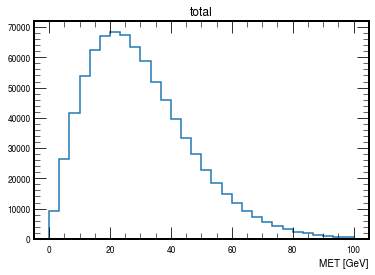

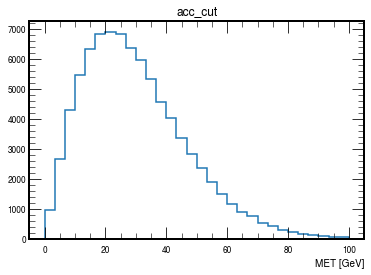

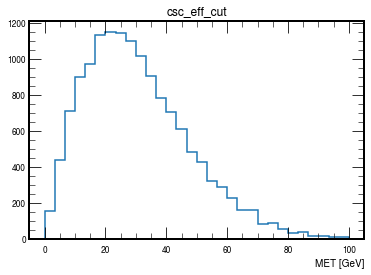

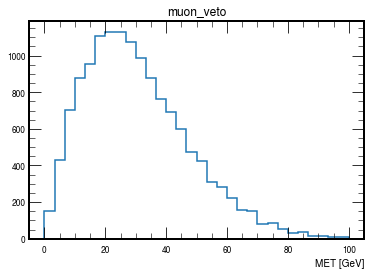

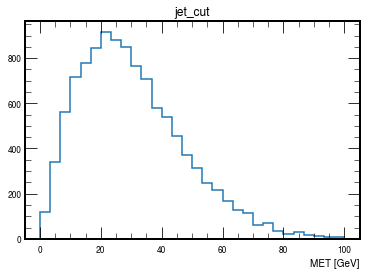

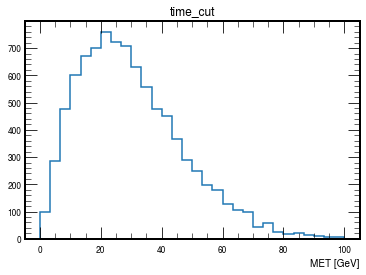

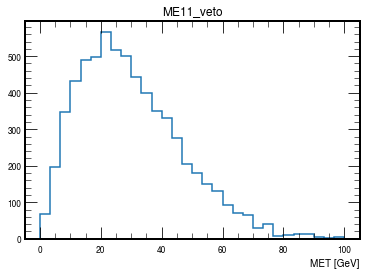

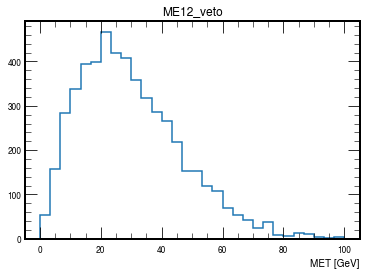

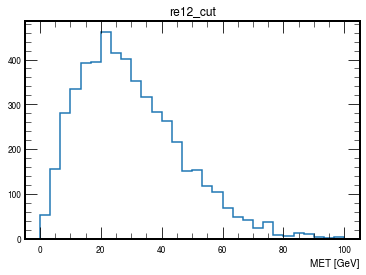

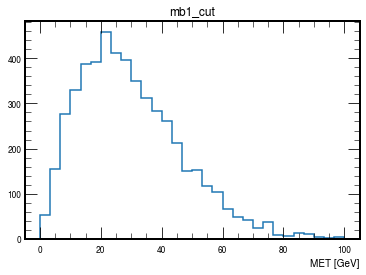

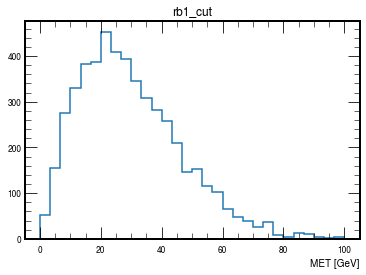

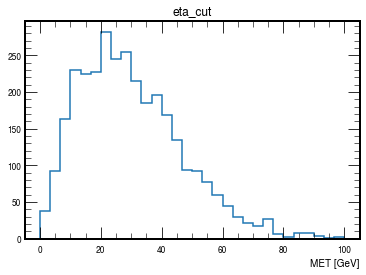

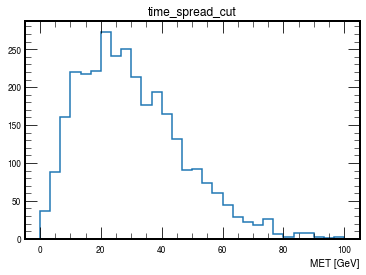

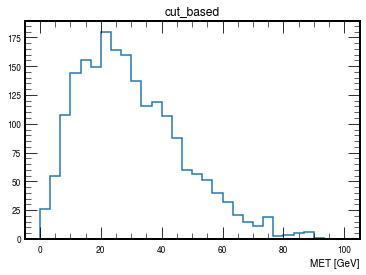

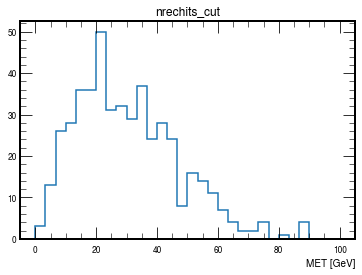

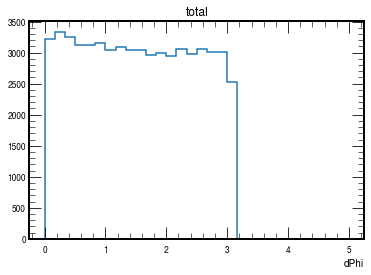

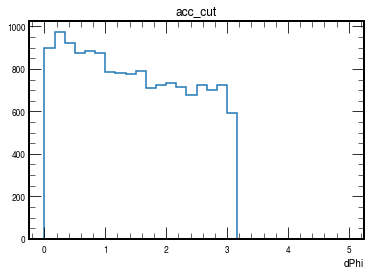

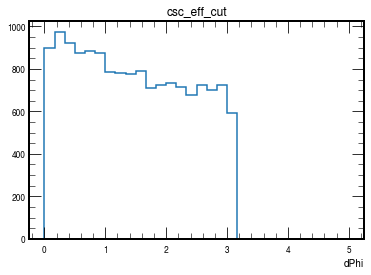

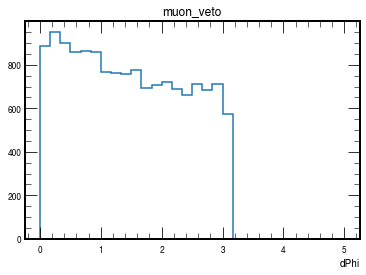

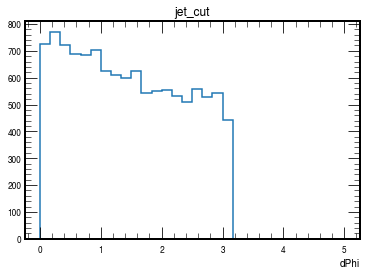

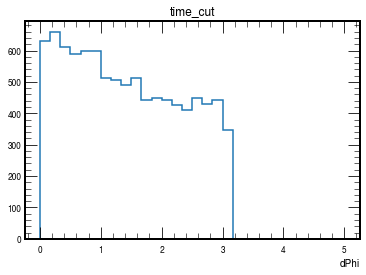

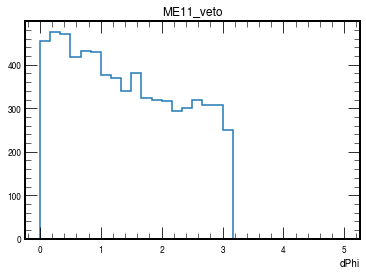

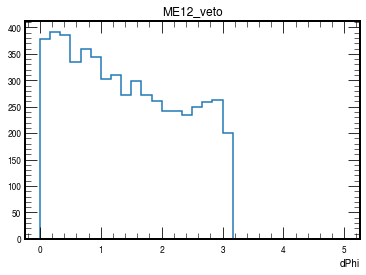

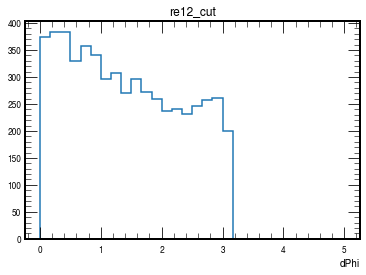

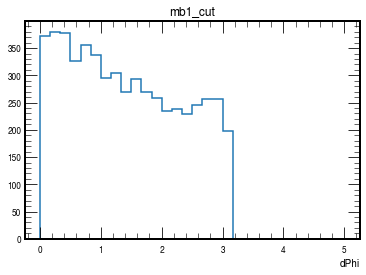

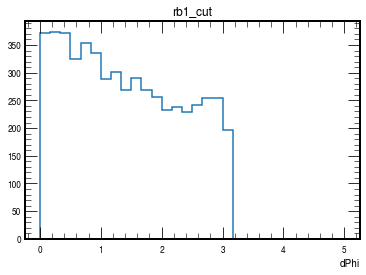

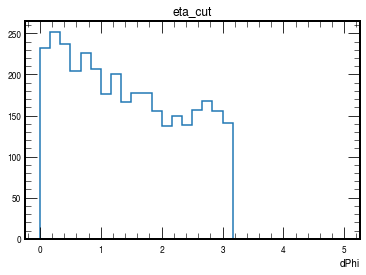

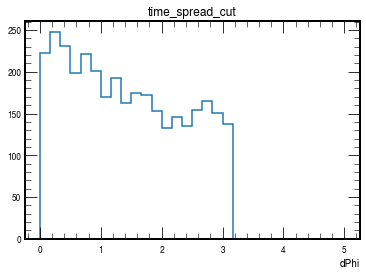

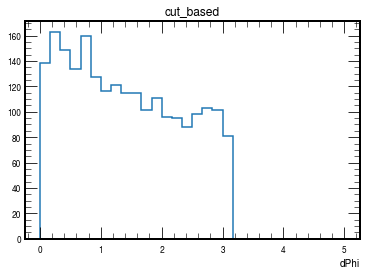

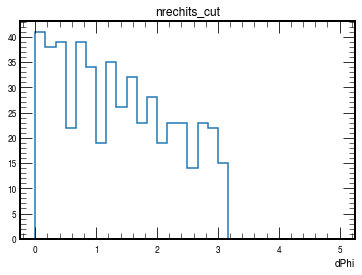

In [149]:
#cuts = ['total', 'acc_cut', 'csc_eff_cut', 'muon_veto', 'jet_cut', 'time_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut', 'eta_cut', 'time_spread_cut', 'cut_based', 'dphi_cut', 'nrechits_cut']
cuts = ['total', 'acc_cut', 'csc_eff_cut', 'muon_veto', 'jet_cut', 'time_cut', 'ME11_veto', 'ME12_veto', 're12_cut', 'mb1_cut', 'rb1_cut', 'eta_cut', 'time_spread_cut', 'cut_based', 'nrechits_cut']

for cut in cuts:
    #print(f"{cut}, {out['BToPhiK'][cut]};") 
    hep.histplot(out['BToPhiK'][f'{cut}_met'])
    plt.title(cut)
    plt.show()


for cut in cuts:
    #print(f"{cut}, {out['BToPhiK'][cut]};") 
    hep.histplot(out['BToPhiK'][f'{cut}_dphi'])
    plt.title(cut)
    plt.show()

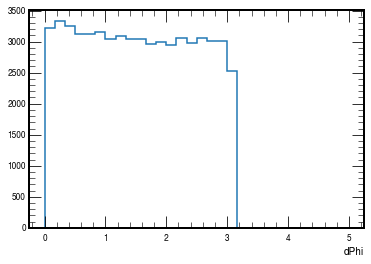

In [148]:
hep.histplot(out['BToPhiK']['total_dphi'])
#plt.title(cut)
plt.show()